In [0]:
import pandas as pd
from sklearn import preprocessing
import datetime
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 500)
import numpy as np
import matplotlib.pyplot as plt

In [0]:

from sklearn.preprocessing import StandardScaler,MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost.sklearn import XGBClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [0]:
#read train and test data
train=pd.read_csv('train_8wry4cB.csv')


In [0]:
train.head()

,session_id,startTime,endTime,ProductList,gender
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male


In [0]:
remove_columns = ['session_id','ProductList','ProductList_list']

In [0]:
def list_encoder(col,val_list,df):
  df[col+'encoded']=df[col].map(lambda x: [i if i in val_list else col+'Others' for i in x])
  dummied_df=pd.get_dummies(df[col+'encoded'].explode()).reset_index().groupby('index').sum()
  df=pd.concat([df,dummied_df],axis=1)
  df.drop(columns=[col,col+'encoded'],inplace=True)
  
  return df

In [0]:
def time_processing(col_name,df):
  df[col_name+'day']=df[col_name].map(lambda x: x.day)
  df[col_name+'month']=df[col_name].map(lambda x: x.month)
  df[col_name+'hour']=df[col_name].map(lambda x: x.hour)
  df[col_name+'daysofweek']=df[col_name].map(lambda x: x.weekday())
  df[col_name+'quarter']=df[col_name].map(lambda x: x.quarter)
  df.drop(columns=col_name,inplace=True)
  return df


In [0]:
def feature_engineering(df):
  df['ProductList_list']=df.ProductList.str.split(';')
  df['Product_Category']=df.ProductList_list.map(lambda x: [i.split('/')[0] for i in x])
  df['session_count']=df.ProductList_list.map(lambda x: len(x))
  df['Product_2nd_Category']=df.ProductList_list.map(lambda x: [i.split('/')[1] for i in x])
  df['Product_3rd_Category']=df.ProductList_list.map(lambda x: [i.split('/')[2] for i in x])
  df['Product_4th_Category']=df.ProductList_list.map(lambda x: [i.split('/')[3] for i in x])
  df['Product_Category']=df.Product_Category.map(lambda x: pd.unique(x))
  df['Product_Category_count']=df.Product_Category.map(lambda x: len(x))
  df['Product_2nd_Category_count']=df.Product_2nd_Category.map(lambda x: len(x))
  df['Product_3rd_Category_Count']=df.Product_3rd_Category.map(lambda x: len(x))
  df['Product_4th_Category_Count']=df.Product_4th_Category.map(lambda x: len(x))
  df=list_encoder('Product_Category',['A00001','A00002','A00003','A00004','A00005'],df)
  df=list_encoder('Product_2nd_Category',['B00001','B00002','B00003','B00004','B00005','B00007','B00012','B00015','B00022'],df)
  df=list_encoder('Product_3rd_Category',['C00028','C00019','C00007','C00003','C00002'],df)
  df=list_encoder('Product_4th_Category',['D00266', 'D01034','D05339','D10307'],df)
  #df['Product_3rd_Category']=df.Product_3rd_Category.map(lambda x: x[0])
  #df['Product_4th_Category']=df.Product_4th_Category.map(lambda x: x[0])
  
  df.startTime=pd.to_datetime(df.startTime)
  df.endTime=pd.to_datetime(df.endTime)
  df['Session_Duration']=df.endTime-df.startTime
  df.Session_Duration=df.Session_Duration.map(lambda x: x.total_seconds())
  df = time_processing('startTime',df)
  df = time_processing('endTime',df)
  #df.drop(columns=remove_columns,inplace=True)
  return df

In [0]:
#Apply feature engineering
train = feature_engineering(train)

In [0]:
train.columns

Index(['session_id', 'ProductList', 'gender', 'ProductList_list',
       'session_count', 'Product_Category_count', 'Product_2nd_Category_count',
       'Product_3rd_Category_Count', 'Product_4th_Category_Count', 'A00001',
       'A00002', 'A00003', 'A00004', 'A00005', 'Product_CategoryOthers',
       'B00001', 'B00002', 'B00003', 'B00004', 'B00005', 'B00007', 'B00012',
       'B00015', 'B00022', 'Product_2nd_CategoryOthers', 'C00002', 'C00003',
       'C00007', 'C00019', 'C00028', 'Product_3rd_CategoryOthers', 'D00266',
       'D01034', 'D05339', 'D10307', 'Product_4th_CategoryOthers',
       'Session_Duration', 'startTimeday', 'startTimemonth', 'startTimehour',
       'startTimedaysofweek', 'startTimequarter', 'endTimeday', 'endTimemonth',
       'endTimehour', 'endTimedaysofweek', 'endTimequarter'],
      dtype='object')

In [0]:
column_list_X = ['Product_Category_count', 'Product_2nd_Category_count',
       'Product_3rd_Category_Count', 'Product_4th_Category_Count', 'A00001',
       'A00002', 'A00003', 'A00004', 'A00005', 'Product_CategoryOthers',
       'B00001', 'B00002', 'B00003', 'B00004', 'B00005', 'B00007', 'B00012',
       'B00015', 'B00022', 'Product_2nd_CategoryOthers', 'C00002', 'C00003',
       'C00007', 'C00019', 'C00028', 'Product_3rd_CategoryOthers', 'D00266',
       'D01034', 'D05339', 'D10307', 'Product_4th_CategoryOthers',
       'Session_Duration', 'startTimeday', 'startTimemonth', 'startTimehour',
       'endTimeday', 'endTimemonth', 'endTimehour','startTimedaysofweek',
       'startTimequarter','endTimedaysofweek', 'endTimequarter','session_count']

target_variable = 'gender'

In [0]:
##Train-Test split..70-30 split
x_train,x_test,y_train,y_test = train_test_split(train, train[target_variable], test_size=0.3, random_state=42)

In [0]:
x_train.shape

(7350, 47)

In [0]:
##Extract only required columns
x_train = x_train[column_list_X]
x_test = x_test[column_list_X]

In [0]:
x_train.shape

(7350, 43)

In [0]:
##Normalize the data
scaling = StandardScaler()
scaling.fit(x_train)
x_train=pd.DataFrame(scaling.transform(x_train),columns=column_list_X)
x_test=pd.DataFrame(scaling.transform(x_test),columns=column_list_X)

In [0]:
x_test.shape

(3150, 43)

In [0]:
def model_fitting(x, y, classifier_name, n_jobs=2):
    """
    The fitting process with sklearn algorithms.
    :param train_set: numpy array, required
    :param train_labels: list, required
    :param classifier_name: string, required
    :param n_jobs: integer, required
    :return: object
        - Fit classifier model according to the given training data
    """

    classifier_list = {"random_forests": RandomForestClassifier(n_estimators=1000, max_depth=5,
                                                                max_features='auto',n_jobs=n_jobs),
                       "GBC": GradientBoostingClassifier(max_depth=10, max_leaf_nodes=850, min_samples_leaf=15, learning_rate=0.1),
                       "XGB": XGBClassifier(learning_rate=0.001,
                                            n_estimators=2000,
                                            max_depth=5,
                                            subsample=1,
                                            colsample_bytree=1,
                                            gamma=0,
                                            min_child_weight=10,
                                            #scale_pos_weight=sum(y_train=='female')/sum(y_train=='male'),
                                            nthread=n_jobs,
                                            early_stopping=100,
                                            seed=42),
                       "NN":MLPClassifier(hidden_layer_sizes=(5, ), activation='relu', solver='adam', 
                                        alpha=0.001, learning_rate='constant', 
                                        learning_rate_init=0.001,
                                        random_state=42, momentum=0.8, early_stopping=True)
                        }

                       
#                        "XGB_RS":RandomizedSearchCV(XGBClassifier(), xgb_param_grid, n_iter=20,
#                             n_jobs=n_jobs, verbose=2, cv=2,
#                             scoring='mean_squared_error', random_state=42)}
    return classifier_list[classifier_name].fit(x, y) 

In [0]:
model=model_fitting(x_train,y_train,"random_forests")

Text(0.5, 0, 'Relative Importance')

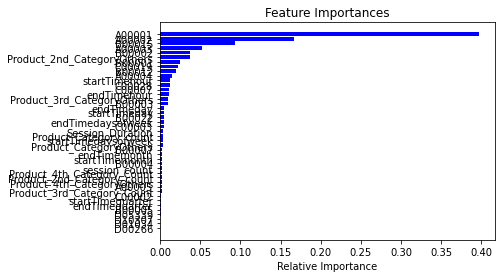

In [0]:
features=x_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [0]:
imp_df=pd.DataFrame({'importance':importances[indices],
'Attribute':features[indices]})

In [0]:
list(imp_df[imp_df.importance>0.005]['Attribute'])

['endTimehour',
 'startTimemonth',
 'startTimehour',
 'C00019',
 'startTimeday',
 'A00005',
 'B00001',
 'endTimedaysofweek',
 'Product_3rd_CategoryOthers',
 'Product_2nd_CategoryOthers',
 'B00002',
 'A00003',
 'Product_2nd_Category_count',
 'A00002',
 'Product_Category_count',
 'Product_CategoryOthers',
 'A00004',
 'A00001']

In [0]:
imp_df.sort_values(by='importance',ascending=False)

,importance,Attribute
42,0.763820,A00001
41,0.052935,A00004
40,0.025588,Product_CategoryOthers
39,0.023849,Product_Category_count
38,0.014975,A00002
37,0.009614,Product_2nd_Category_count
36,0.009213,A00003
35,0.008887,B00002
34,0.007729,Product_2nd_CategoryOthers
33,0.006889,Product_3rd_CategoryOthers


In [0]:
y_pred=model.predict(x_test)

In [0]:
cnf = metrics.confusion_matrix(y_pred=y_pred,y_true=y_test)

In [0]:
cnf

array([[2361,   91],
       [ 337,  361]])

In [0]:
print(metrics.accuracy_score(y_pred=y_pred,y_true=y_test))
print(metrics.f1_score(y_pred=y_pred,y_true=y_test,average='weighted'))


0.8641269841269841
0.8528396014660262


In [0]:
#GBC - 0.8726984126984128
#NN - 0.8714285714285714
#XGB - 0.8771428571428571
#RF - 0.8644444444444445

In [0]:
##evaluation data preperation
test = pd.read_csv('test_Yix80N0.csv')
#Apply feature engineering
test_df = feature_engineering(test)

##Extract only required columns
test_df = test_df[column_list_X]
#scaling
test_df=pd.DataFrame(scaling.transform(test_df),columns=column_list_X)


In [0]:
submission_file=pd.DataFrame({'session_id':test['session_id'].values,'gender':model.predict(test_df)})
submission_file.to_csv('Submissions_NN.csv',index=False)